### Data Mining and Machine Learning
### Recommendation system using Deep Learning
### Edgar Acuna
### March 2022
#### Using deep Learning neural to create a recommendation system
#### Based on https://towardsdatascience.com/building-a-book-recommendation-system-using-keras-1fba34180699

In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split

### Example 1. Books recommendation

In [72]:
dataset = pd.read_csv('https://academic.uprm.edu/eacuna/books_ratings.csv')
dataset.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [73]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
n_users = len(dataset.user_id.unique())
n_books = len(dataset.book_id.unique())
print('number of users:',n_users,"number of books:",n_books)

number of users: 53424 number of books: 10000


In [74]:
#Building the model
from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)
prod = Dot(name="Dot-Product", axes=1)([book_vec, user_vec])
model = Model([user_input, book_input], prod)
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Book-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Book-Embedding (Embedding)      (None, 1, 5)         50005       Book-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         267125      User-Input[0][0]                 
______________________________________________________________________________________

In [75]:
#Training the model using only 5 epochs
model.compile('adam', 'mean_squared_error')
history = model.fit([train.user_id, train.book_id], train.rating, epochs=5, verbose=1)
model.save('regression_model.h5')

Epoch 1/5
24544/24544 [==============================] - 78s 3ms/step - loss: 13.4585
Epoch 2/5
24544/24544 [==============================] - 81s 3ms/step - loss: 3.8993
Epoch 3/5
24544/24544 [==============================] - 78s 3ms/step - loss: 1.6317
Epoch 4/5
24544/24544 [==============================] - 80s 3ms/step - loss: 1.1390
Epoch 5/5
24544/24544 [==============================] - 80s 3ms/step - loss: 0.9393


In [76]:
# Extract embeddings
book_em = model.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]
book_em_weights

array([[ 0.02870991,  0.04324968,  0.01223991, -0.03951379, -0.03449032],
       [ 0.26837388,  0.91811115, -1.4217894 ,  1.3117625 ,  1.4510367 ],
       [-0.35657805,  0.77727014, -1.3390515 ,  1.3671173 ,  1.2673235 ],
       ...,
       [ 1.7061064 ,  1.6825444 , -1.454468  ,  1.6933446 ,  1.7315444 ],
       [ 1.5148063 ,  1.3822528 , -1.322201  ,  1.8331801 ,  1.4078523 ],
       [ 1.7709571 ,  1.510309  , -1.1362133 ,  1.419295  ,  1.7152867 ]],
      dtype=float32)

### Visualizing the embeddings using PCA

<AxesSubplot:>

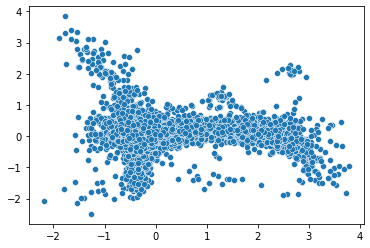

In [77]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as pyplt
import seaborn as sns
%matplotlib inline
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

### Visualizing the embeddings using TSNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.014s...
[t-SNE] Computed neighbors for 10001 samples in 0.549s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 0.101531
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.827812
[t-SNE] KL

<AxesSubplot:>

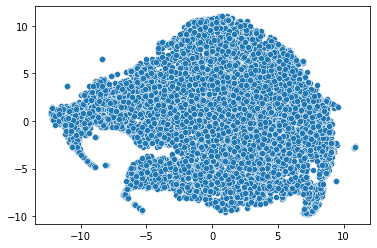

In [78]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(book_em_weights)
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

#### Creating dataset for making recommendations for the first user

In [79]:
# Creating dataset for making recommendations for the first user
import numpy as np
book_data = np.array(list(set(dataset.book_id)))
user = np.array([1 for i in range(len(book_data))])
predictions = model.predict([user, book_data])
predictions = np.array([a[0] for a in predictions])
recommended_book_ids = (-predictions).argsort()[:5]
#showing the top-5 recommended books
print(recommended_book_ids)

[7638 8998 8258 9517 4942]


In [80]:
#Ratings for the recommended books
print(predictions[recommended_book_ids])

[4.8299136 4.7921963 4.7377467 4.6639524 4.644611 ]


In [81]:
books = pd.read_csv('https://academic.uprm.edu/eacuna/books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [82]:
print(books[books['id'].isin(recommended_book_ids)])

        id   book_id  best_book_id   work_id  books_count        isbn  \
4941  4942     48467         48467   1046530           60   374530637   
7637  7638     12009         12009   2465248           28  1597800449   
8257  8258  18594594      18594594  26341000           41   345547497   
8997  8998    292740        292740   2457130           37  2266071289   
9516  9517     17810         17810    856346           39         NaN   

            isbn13                       authors  original_publication_year  \
4941  9.780375e+12             Flannery O'Connor                     1952.0   
7637  9.781598e+12                 Iain M. Banks                     2004.0   
8257  9.780346e+12               Karin Slaughter                     2014.0   
8997  9.782266e+12            Lorenzo Carcaterra                     1995.0   
9516  9.780143e+12  Ryū Murakami, Ralph McCarthy                     1997.0   

      original_title  ... ratings_count work_ratings_count  \
4941      Wise Blood  ..

### Example 2: Movies Recommendation

In [83]:
#Reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
url='https://files.grouplens.org/datasets/movielens/ml-100k/u.data'
ratings = pd.read_csv(url, sep='\t', names=r_cols,encoding='latin-1')
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [84]:
dataset=ratings[["user_id","movie_id","rating"]]

In [85]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
n_users = len(dataset.user_id.unique())
n_movies = len(dataset.movie_id.unique())
print('number of users:',n_users,"number of books:",n_movies)

number of users: 943 number of books: 1682


In [86]:
#Building the model
from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model
movie_input = Input(shape=[1], name="movie-Input")
movie_embedding = Embedding(n_movies+1, 5, name="movie-Embedding")(movie_input)
movie_vec = Flatten(name="Flatten-movies")(movie_embedding)
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)
prod = Dot(name="Dot-Product", axes=1)([movie_vec, user_vec])
model = Model([user_input, movie_input], prod)
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie-Input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie-Embedding (Embedding)     (None, 1, 5)         8415        movie-Input[0][0]                
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         4720        User-Input[0][0]                 
______________________________________________________________________________________

In [87]:
#Training the model using only 20 epochs
model.compile('adam', 'mean_squared_error')
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=50, verbose=1)
model.save('regression_model.h5')

Epoch 1/50
2500/2500 [==============================] - 1s 492us/step - loss: 11.2088
Epoch 2/50
2500/2500 [==============================] - 1s 494us/step - loss: 3.0657
Epoch 3/50
2500/2500 [==============================] - 1s 532us/step - loss: 1.4490 0s -
Epoch 4/50
2500/2500 [==============================] - 1s 540us/step - loss: 1.0969
Epoch 5/50
2500/2500 [==============================] - 1s 592us/step - loss: 0.9770
Epoch 6/50
2500/2500 [==============================] - 2s 603us/step - loss: 0.9279
Epoch 7/50
2500/2500 [==============================] - 1s 558us/step - loss: 0.9052 1s - loss: 0.8 - ETA:
Epoch 8/50
2500/2500 [==============================] - 1s 536us/step - loss: 0.8927
Epoch 9/50
2500/2500 [==============================] - 1s 542us/step - loss: 0.8850
Epoch 10/50
2500/2500 [==============================] - 1s 553us/step - loss: 0.8798
Epoch 11/50
2500/2500 [==============================] - 1s 562us/step - loss: 0.8763 0s - l - ETA: 0s - loss:
Epoch 12/5

In [88]:
# Extract embeddings for movie
movie_em = model.get_layer('movie-Embedding')
movie_em_weights = movie_em.get_weights()[0]
movie_em_weights

array([[ 0.02223763, -0.03386669,  0.00388676, -0.02791935, -0.04286494],
       [ 0.93866956,  0.5802673 ,  0.7659108 , -1.4247928 , -0.74787587],
       [ 1.0068488 ,  0.38045052,  0.914246  , -0.62869424, -0.69123   ],
       ...,
       [ 0.42700467,  0.47520965,  0.47856727, -0.43146262, -0.44980946],
       [ 0.84181803,  0.8255404 ,  0.7710388 , -0.84311646, -0.8395454 ],
       [-0.0318255 , -0.03483471, -0.02213058,  0.04589433, -0.00842516]],
      dtype=float32)

In [89]:
# Extract embeddings for users
user_em = model.get_layer('User-Embedding')
user_em_weights = user_em.get_weights()[0]
user_em_weights

array([[ 0.03623528, -0.02030432, -0.03618081, -0.0159932 , -0.01783192],
       [ 0.5189696 ,  1.4215575 ,  0.849957  , -0.68566245, -1.0872531 ],
       [ 0.7394154 ,  1.416669  ,  0.684911  , -0.7524218 , -1.0945551 ],
       ...,
       [ 1.0335572 ,  1.0673968 ,  0.7492629 , -1.1012307 , -1.0119209 ],
       [ 1.121207  ,  0.18781802,  1.0459521 , -1.5154827 , -0.92741805],
       [ 1.0963198 ,  1.2304108 ,  0.16241935, -0.47721976, -1.5549239 ]],
      dtype=float32)

In [90]:
# Creating dataset for making recommendations for the first user
import numpy as np
movie_data = np.array(list(set(dataset.movie_id)))
#print(movie_data)
user = np.array([1 for i in range(len(movie_data))])
#print(user)
predictions = model.predict([user, movie_data])
#print(predictions)
predictions = np.array([a[0] for a in predictions])
#print(predictions)

In [91]:
#recommended movies for first user
recommended_movies_ids = (-predictions).argsort()[:10]
#showing the top-10 recommended movies
print(recommended_movies_ids)

[1641 1499 1305 1652 1367 1628 1397 1448 1366 1404]


In [92]:
#Reading items file where the category of the movie is included
i_cols = ['movie_id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
url='https://files.grouplens.org/datasets/movielens/ml-100k/u.item'
movies = pd.read_csv(url, sep='|', names=i_cols,encoding='latin-1')
movies

,movie_id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
print(movies[movies['movie_id'].isin(recommended_movies_ids)])

      movie_id                                movie title release date  \
1304      1305      National Lampoon's Senior Trip (1995)  01-Jan-1995   
1365      1366  JLG/JLG - autoportrait de décembre (1994)  01-Jan-1994   
1366      1367                               Faust (1994)  01-Jan-1994   
1396      1397                    Of Human Bondage (1934)  01-Jan-1934   
1403      1404                      Withnail and I (1987)  01-Jan-1987   
1447      1448                  My Favorite Season (1993)  19-Apr-1996   
1498      1499                      Grosse Fatigue (1994)  01-Jan-1994   
1627      1628                            Lamerica (1994)  01-Jan-1994   
1640      1641                            Dadetown (1995)  18-Sep-1996   
1651      1652           Temptress Moon (Feng Yue) (1996)  13-Jun-1997   

      video release date                                           IMDb URL  \
1304                 NaN  http://us.imdb.com/M/title-exact?National%20La...   
1365                 NaN  h